In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox

from matplotlib import pyplot as plt
from itertools import product
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
data=pd.read_csv('https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/master/data/widget_sales.csv')

In [6]:
data.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


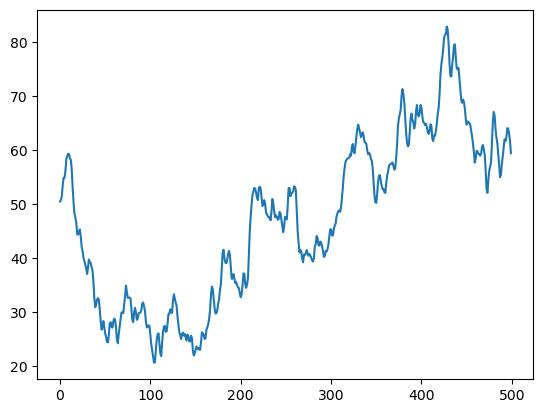

In [7]:
plt.plot(data)

In [8]:
print(adfuller(data)[0],adfuller(data)[1])

-1.5121662069359048 0.5274845352272605


It is not stationary

In [11]:
#making it stationary
diff_data=np.diff(data['widget_sales'],n=1)
print(adfuller(diff_data)[0],adfuller(diff_data)[1])

-10.576657780341959 7.076922818587193e-19


Now it is stationary so d=1

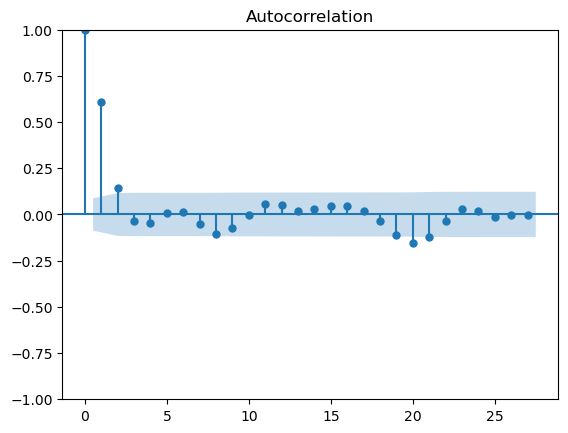

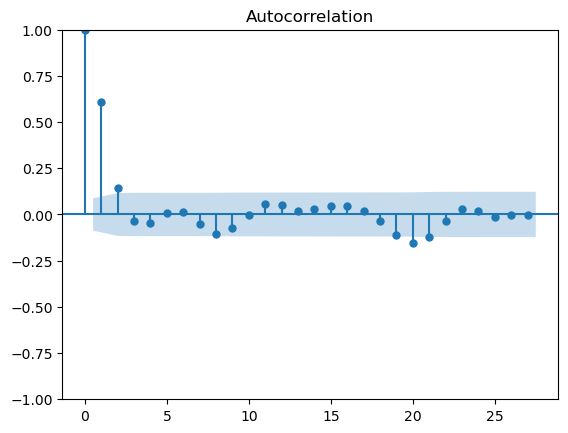

In [12]:
#plotting 
plot_acf(diff_data)

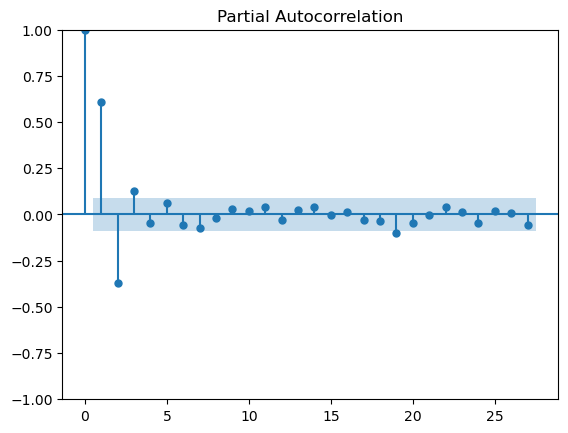

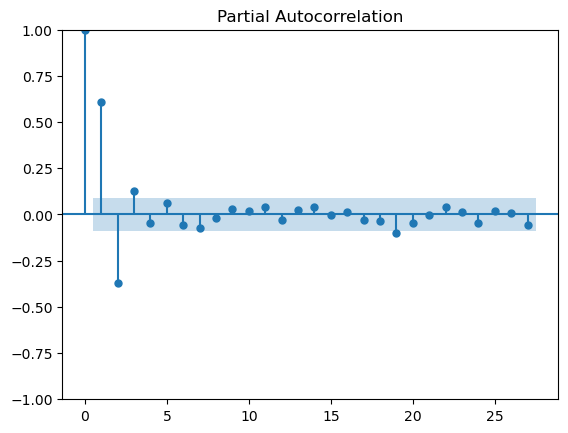

In [13]:
#plotting 
plot_pacf(diff_data)

In [15]:
train=data[:-50]
test=data[-50:]

In [27]:
def arima(order_list,d,df):
    result=[]
    for i in order_list:
        model=SARIMAX(endog=df,order=(i[0],d,i[1]),simple_differencing=False).fit(disp=False)
        aic=model.aic
        result.append([i,aic])
    result=pd.DataFrame(result)
    result.columns=['order','aic']
    result.sort_values(by='aic',inplace=True)
    return result

In [29]:
model = SARIMAX(train, order=(3,1,3), simple_differencing=False)
model_fit = model.fit(disp=False)

print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:           widget_sales   No. Observations:                  450
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -618.713
Date:                Wed, 31 May 2023   AIC                           1251.426
Time:                        10:29:23   BIC                           1280.175
Sample:                             0   HQIC                          1262.758
                                - 450                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3628      0.064     21.194      0.000       1.237       1.489
ar.L2         -1.3526      0.065    -20.846      0.000      -1.480      -1.225
ar.L3          0.3508      0.064      5.460      0.0

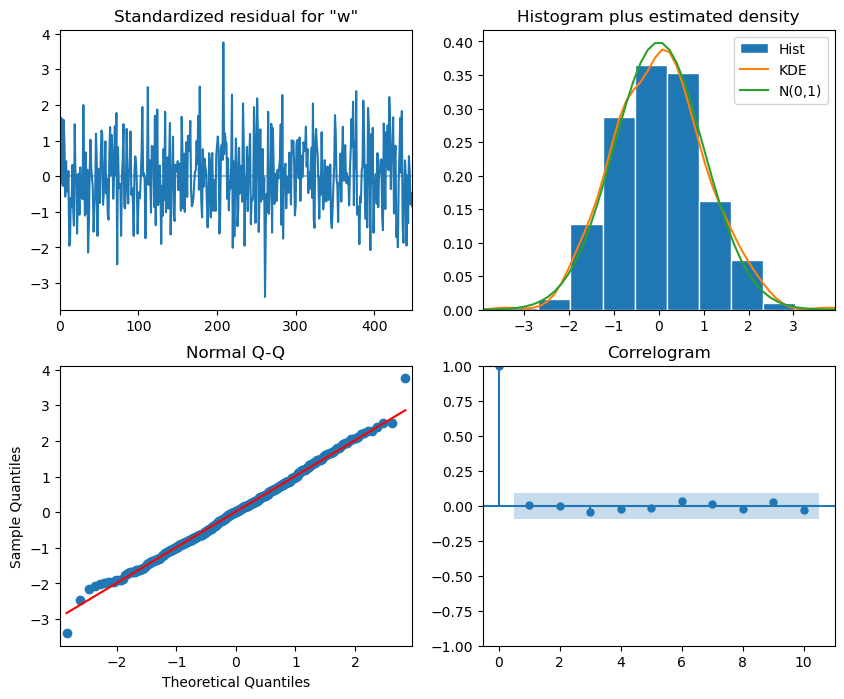

In [30]:
model_fit.plot_diagnostics(figsize=(10,8));

In [32]:
residuals = model_fit.resid

d = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(d)

     lb_stat  lb_pvalue
1   0.017755   0.893996
2   0.045524   0.977495
3   0.241868   0.970563
4   0.263741   0.992033
5   0.284215   0.997929
6   0.704641   0.994390
7   0.828687   0.997140
8   0.903199   0.998789
9   0.953156   0.999538
10  1.003627   0.999825


In [28]:
ps=range(0,4,1)
qs=range(0,4,1)
d=1
order_list=list(product(ps,qs))

arima(order_list,d,train)

,order,aic
15,"(3, 3)",1251.425849
2,"(0, 2)",1254.409302
9,"(2, 1)",1254.961827
3,"(0, 3)",1255.826822
12,"(3, 0)",1255.967595
6,"(1, 2)",1255.982548
5,"(1, 1)",1256.284513
13,"(3, 1)",1256.850863
10,"(2, 2)",1256.918179
7,"(1, 3)",1257.643258


In [36]:
def forecasting(train_len,test_len,window,df,type_):
    total_len=train_len+test_len
    
    if type_=='mean':
        mean_list=[]
        for i in range(train_len,total_len,window):
            value=np.mean(df[:i].values)
            mean_list.extend(value for _ in range(window))
        return mean_list
    elif type_=='last':
        last_list=[]
        for i in range(train_len,total_len,window):
            value=df[:i].iloc[-1].values[0]
            last_list.extend(value for _ in range(window))
        return last_list
    else:
        arima_list=[]
        for i in range(train_len,total_len,window):
            model=SARIMAX(endog=df[:i],order=(3,1,3),simple_differencing=False).fit(disp=False)
            predictions = model.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            arima_list.extend(oos_pred)
        return arima_list

In [37]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 2

pred_mean = forecasting(TRAIN_LEN,HORIZON,WINDOW,data,'mean')
pred_last_value = forecasting(TRAIN_LEN,HORIZON,WINDOW,data, 'last')
pred_ARIMA = forecasting(TRAIN_LEN,HORIZON,WINDOW,data, 'ARIMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARIMA'] = pred_ARIMA

test.head()

,widget_sales,pred_mean,pred_last_value,pred_ARIMA
450,64.736005,45.472231,65.906136,64.811784
451,65.316972,45.472231,65.906136,64.718856
452,65.172070,45.558754,65.316972,66.241317
453,65.075506,45.558754,65.316972,66.606349
454,64.703173,45.644943,65.075506,64.993952


In [38]:
mean_mae = mean_absolute_error(test['widget_sales'], test['pred_mean'])
last_mae = mean_absolute_error(test['widget_sales'], test['pred_last_value'])
ARIMA_mae = mean_absolute_error(test['widget_sales'], test['pred_ARIMA'])

print(mean_mae, last_mae, ARIMA_mae)

14.220336729946744 1.819226540180243 1.572447759552384
